# Building makemore Part 3: Activations & Gradients, BatchNorm



In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# SUMMARY + PYTORCHIFYING -----------

In [ ]:

# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    # kaiming init
    # If we forgot the / fan_in**0.5 here, it's still ok if we are adding batch norm,
    # we just need to adjust (usually larger) the learning rate according the update_to_data plot
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    # attribute .out is for getting the stats easily, not in pytorch
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        # buffers are trained using exponenial moving average
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  # BatchNorm1d layers are typcally placed right after linear layer before nonlinearity layer,
  # but people have been play with it, and it should get the simialr results if we place it after the  nonlinearity layer.
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  # We can also place batch norm layer after the last linear layer before the loss func
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# layers without batch norm layer
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  # which later in the plots, we can see the last layer is an outlier
  # layers[-1].weight *= 0.1
  # Because the last layer is batch norm, we'll be changing the gamma instead of weights
  layers[-1].gamma *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      #
      layer.weight *=  #5/3 # 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # keep track of the update-to-data ratio, in log10
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


### plot paramters to check if things are well calibrated
Adding batch norm layer makes it less required to choose the right gain,
too low or too high gain resulting the similar good distruibutions of activation, grad and weights grad, because batch norm makes training more robust. But the scale of update-to-data is effected if gain is set too high or too low, so we can adjust the learning rate accordingly.

Batch norm makes training more robust, even if we forgot / fan_in**0.5 when init the weights and set gain to 1 (no gain), we can still get good results. We just need to adjust (usually larger) the learning rate according the update_to_data plot.



layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 5 (      Tanh): mean +0.00, std 0.66, saturated: 2.00%
layer 8 (      Tanh): mean +0.00, std 0.66, saturated: 1.47%
layer 11 (      Tanh): mean +0.00, std 0.66, saturated: 1.22%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 0.72%


Text(0.5, 1.0, 'activation distribution')

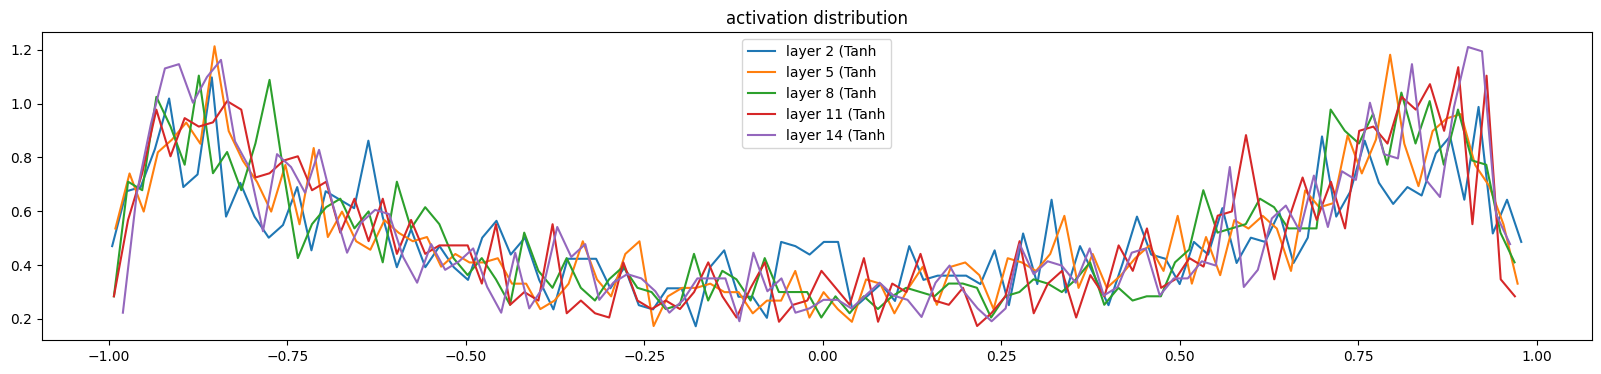

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 1.249226e-03
layer 5 (      Tanh): mean -0.000000, std 1.097230e-03
layer 8 (      Tanh): mean +0.000000, std 9.477235e-04
layer 11 (      Tanh): mean +0.000000, std 9.355879e-04
layer 14 (      Tanh): mean +0.000000, std 1.049950e-03


Text(0.5, 1.0, 'gradient distribution')

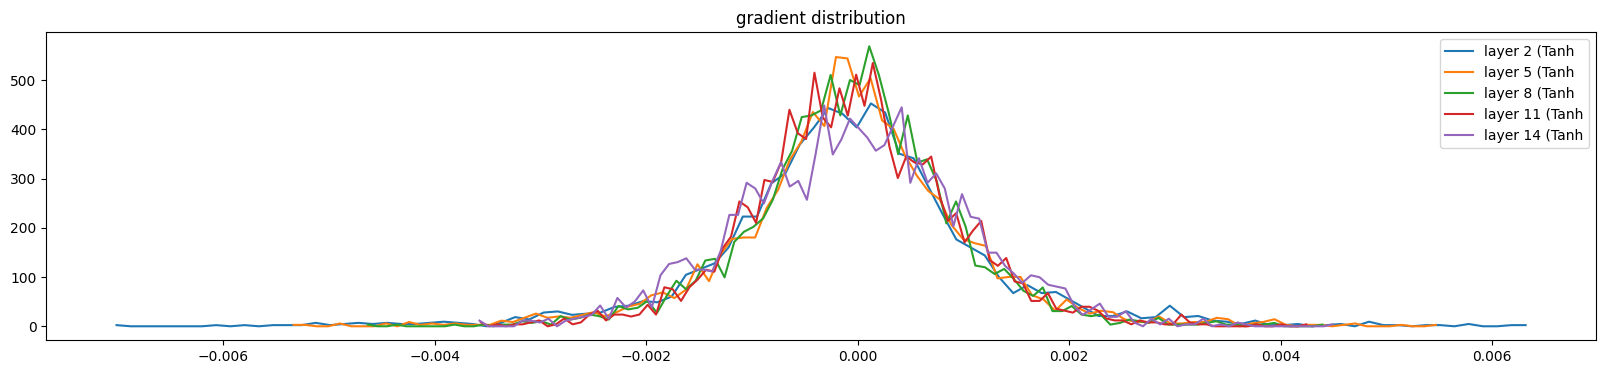

In [ ]:
# visualize histograms
# the last layer is an outlier because we artificially make it less confident
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 7.373104e-03 | grad:data ratio 7.366225e-03
weight  (30, 100) | mean +0.000311 | std 1.391910e-02 | grad:data ratio 2.291524e-01
weight (100, 100) | mean +0.000029 | std 6.005445e-03 | grad:data ratio 2.009050e-01
weight (100, 100) | mean -0.000016 | std 5.219661e-03 | grad:data ratio 1.905846e-01
weight (100, 100) | mean -0.000050 | std 5.058508e-03 | grad:data ratio 1.921146e-01
weight (100, 100) | mean -0.000113 | std 5.221349e-03 | grad:data ratio 2.003026e-01
weight  (100, 27) | mean +0.000016 | std 1.234927e-02 | grad:data ratio 2.863972e-01


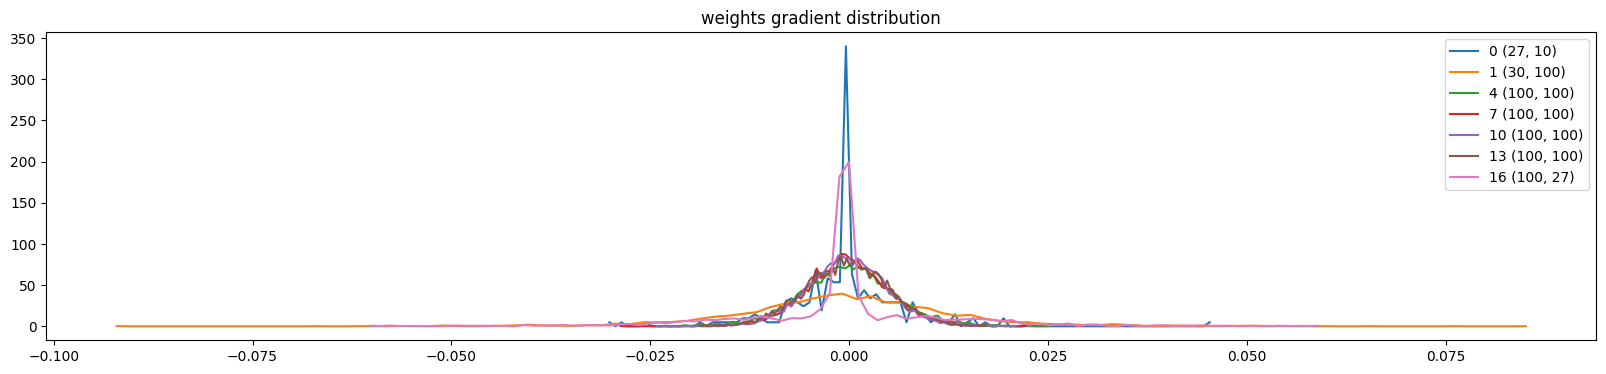

In [ ]:
# visualize histograms
# the last layer is an outlier because we artificially make it less confident
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # plot just the weights, not biases for simplicity
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

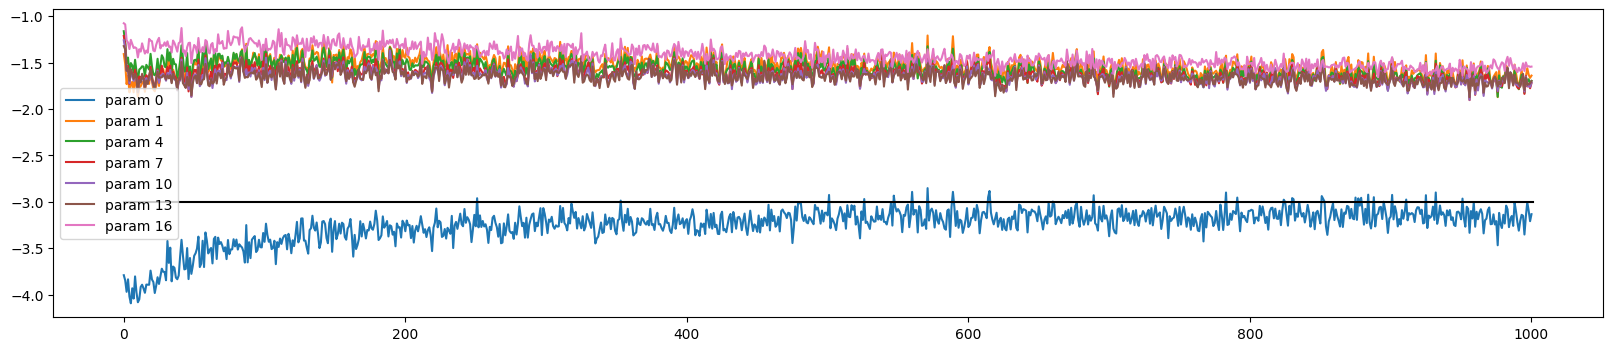

In [ ]:
# It should be not too above -3.
# If it's below -3, usually it means the parameters are not trained fast enough.
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
# Learning details -----------

### batch norm
intuition: we want the hidden states hpreact (hidden layer pre-activation) to be roughly gaussian. Because if too small then tanh won't be doing anything, if too large then tanh will be too saturated. And the calculations are perfectly differentialble.
So we normalize hpreact.
And we want hpreact to be roughly gaussian only at init, we don't want to force it to be gaussian always.We like the distribution to be able to move around, told be the backprop.
So we use scale and shift. Init scale (bngain) as 1s and shift (bnbias) as 0s, so that in the init it's gaussian and during optimization we'll be able to backprop the bngain and bnbias so the network has the full ablity to do whatever it wants.

In large network, it's better&easier to 'sprinkle' batch norm layers throughout the network. It's common to append a atch norm layer right after a linear layer or convolutional layer, to control these activations at every point in the network.

Good sideeffect comes from batch norm: regularization.
Each hpreact will change a little depend on the mean and std of that batch, so the h will change s little coresspondingly. The change of h introduces some entropy/noise (also like a form of data augmentation), equivelent to regularization, which is a good thing in network training.

People trying to use other norm techniques that do not couple the examples in a batch, eg. layer norm, instance norm, group norm, etc., but it's been hard to remove batch norm because it works so well due to its regularizing effect.

In the test/inference stage, how are we gonna get prediction of a single input if the model is expecting batch inputs?
One way to solve this is to add one more step to calculate the mean and std of the batch norm over the entire training set (called calibrating the batch norm stat).
Another (perferred, and implememted in pytorch) way is to estimate the bnmean and bnstd during training in a running mean manner, so that we don't need a separate stage for calculating the bnmean and bnstd after training.

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# We want the std of hpreact( = embcat @ W1 + b1, ignoring b1 since we set it to very small ) to be 1,
# so we need to mutiply W1 with a small number.
# For tanh， it's (5/3)/((fan_in)**0.5).
# Different nonlinearilty requires diff factor number, check torch.nn.init.kaiming_normal_()
# kaiming_normal_ is the most popular way of init
# You can also init the grad(mode='fan_out'), instead of activation(mode='fan_in'),
# choose one of them as these two don't diff too much.
# Back in 2015 when the kaiminng normal paper published, we had to be extremely careful
# with the activations and grads, especially when the nn is very deep.
# Later a number of moderm innovations (eg.
# 1. residual connections,
# 2. batch norm, layer norm, group norm
# 3. better optimizers: adam, RMSprop)
# make things more stable and well-behaved, so it
# became less imortant to init the networks "extactly right".

# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
# fan_in here: n_embd * block_size
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
# When using batch norm, no need b1 since batch norm has its own bias bnbias
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
# scale W2 to very small numbers and make b2 zero,
# so the logits are more close to 0 in the init
# scale W2 to very small numbers but not 0, so it gets some low entropy,
# which is used for symmetry breaking
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
# init as 1s
bngain = torch.ones((1, n_hidden))
# init as 0s
bnbias = torch.zeros((1, n_hidden))
# bnmean_running, bnmean_running, for estimate the mean and std of the entire training set,
# so they can be used during test/inference stage
# Beacuse we init hpreact roughly gaussian, so we init bnmean_running to be 0s
# and bnstd_running to be 1s as well
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
# parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

  # Linear layer
  # When using batch norm, no need b1 since batch norm has its own bias bnbias
  hpreact = embcat @ W1 #+  b1 # hidden layer pre-activation
  # BatchNorm layer
  # # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  # We can add a small number after bnstdi to prevent dividing by 0
  # hpreact = bngain * (hpreact - bnmeani) / (bnstdi ** 2 + 0.00001) ** 0.5 + bnbias
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

  # We update the bnmean_running, bnstd_running, but no need for grad
  # and we update them in a running mean manner
  # In practice, this way gives the very similar resuslting bnmean and bnstd,
  # but with the benefit of no separate stage for calculating the bnmean and bnstd
  with torch.no_grad():
    # The 0.001 here is called momentum in pytorch.
    # When batch_size is large, momentum can be relatively large, like 0.1 in default,
    # but otherwise it shhould be relatively small.
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [ ]:
# in the init, all prob should be the same and close to 0,
# so we expect the loss of the first iteration should be around 3,
# but we get 27, which means the network is very improperly configed in the init.
# if we print the logits of the first iteration, we can see some extrem values,
# thses logits should be more close to zero.
-torch.tensor(1/27).log()

tensor(3.2958)

In [ ]:
logits[0]

tensor([-3.6392,  2.0350, -0.5161, -1.3322,  0.0336,  2.2695, -1.7004, -1.2365,
        -0.3254,  2.7634, -2.4754, -0.2561,  2.6755,  1.6779,  3.6725,  1.0536,
        -0.4495, -4.2429,  1.9195,  1.5596,  0.6627, -1.8719, -0.2681, -1.6027,
        -2.1775,  2.7475, -0.2072], grad_fn=<SelectBackward0>)

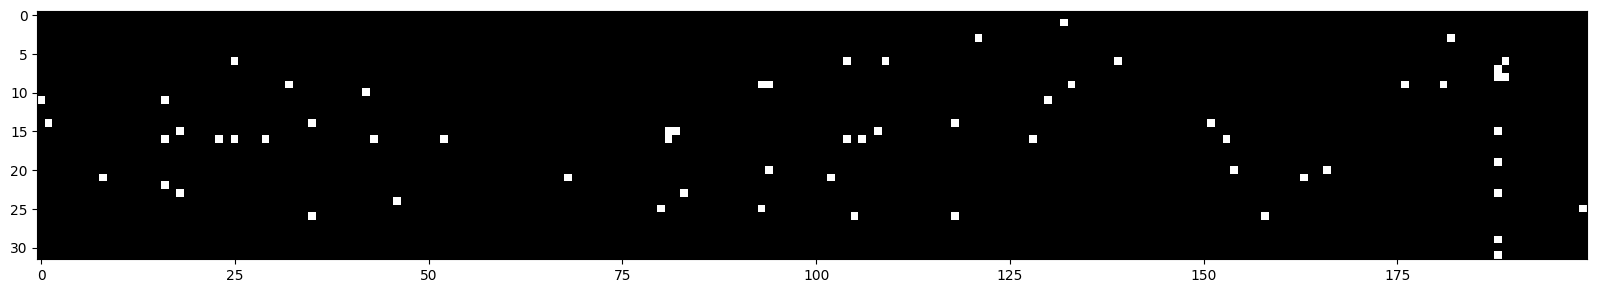

In [ ]:
# when W1, b1 is small, this is init should be
plt.figure(figsize=(20, 10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

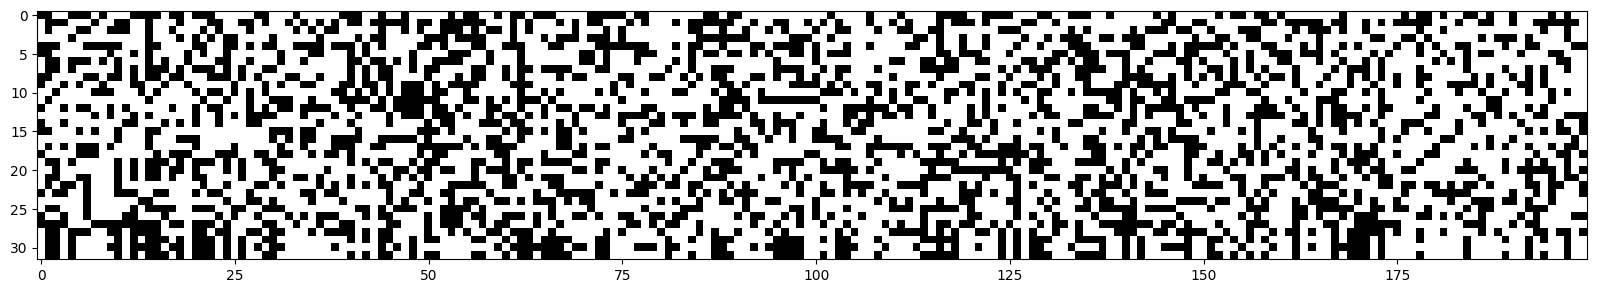

In [ ]:
# # when W1, b1 is large
# # 32 examples and 200 neurons each.
# # no single white column, so no dead neurons,
# # but this is not optimal either, especially during init
# # because too many extrem values in hpreact, the tanh is too saturated,
# # which means there is less training/updates in these neurons.
# plt.figure(figsize=(20, 10))
# plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

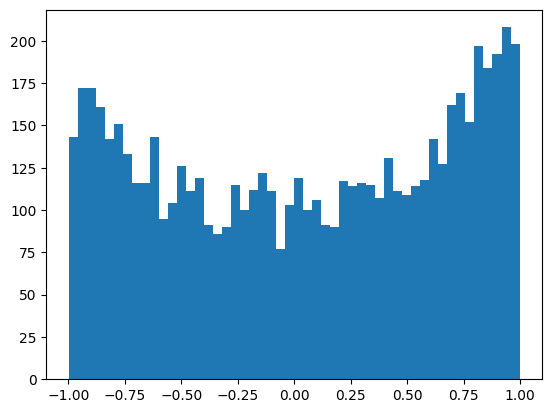

In [ ]:
# when W1, b1 is small, this is init should be
# add ; at the end to suppress the array output
# tanh is very active
# the distribution of preactivations are very broad, -15~15, that's why most of h are 1s and -1s
# it's problematic becase most of them are 1s and -1s, the gradients are desttoyed
plt.hist(h.view(-1).tolist(), 50);

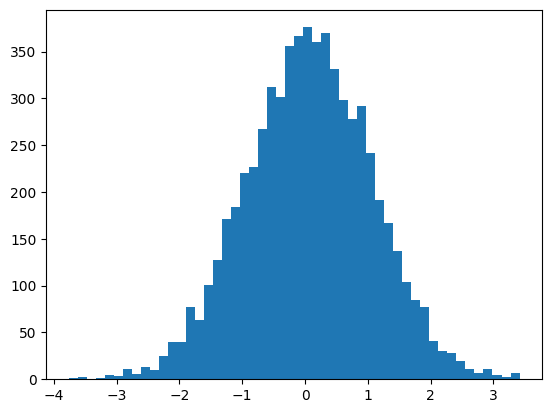

In [ ]:
# when W1, b1 is small, this is init should be
plt.hist(hpreact.view(-1).tolist(), 50);

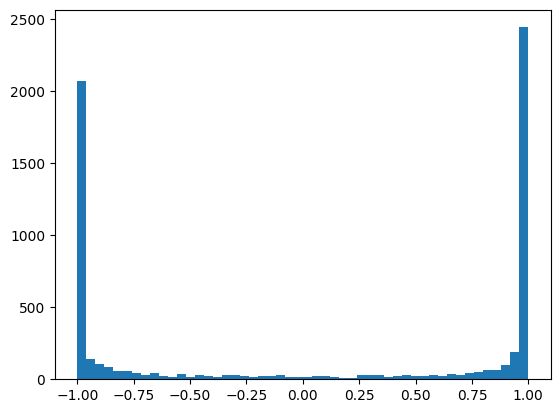

In [ ]:
# # when W1, b1 is large
# # add ; at the end to suppress the array output
# # tanh is very active
# # the distribution of preactivations are very broad, -15~15, that's why most of h are 1s and -1s
# # it's problematic becase most of them are 1s and -1s, the gradients are desttoyed
# plt.hist(h.view(-1).tolist(), 50);

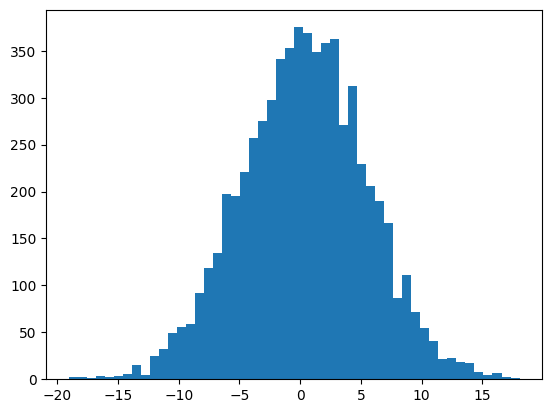

In [ ]:
# # when W1, b1 is large
# plt.hist(hpreact.view(-1).tolist(), 50);

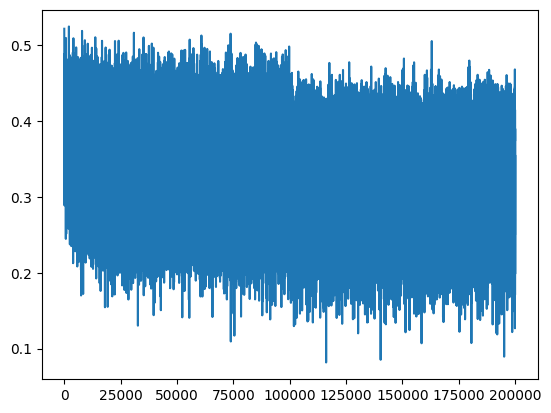

In [ ]:
# when W1, b1 is large
# this loss plot is more healthy than the hockey stick one below,
# we should expect this one when training the network
plt.plot(lossi)

In [ ]:
# # same optimization as last time
# max_steps = 200000
# batch_size = 32
# lossi = []

# for i in range(max_steps):

#   # minibatch construct
#   ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
#   Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

#   # forward pass
#   emb = C[Xb] # embed the characters into vectors
#   embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
#   # Linear layer
#   hpreact = embcat @ W1 + b1 # hidden layer pre-activation
#   # Non-linearity
#   h = torch.tanh(hpreact) # hidden layer
#   logits = h @ W2 + b2 # output layer
#   loss = F.cross_entropy(logits, Yb) # loss function

#   # backward pass
#   for p in parameters:
#     p.grad = None
#   loss.backward()

#   # update
#   lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
#   for p in parameters:
#     p.data += -lr * p.grad

#   # track stats
#   if i % 10000 == 0: # print every once in a while
#     print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
#   lossi.append(loss.log10().item())


      0/ 200000: 27.8817
  10000/ 200000: 2.9415
  20000/ 200000: 2.5069
  30000/ 200000: 2.7998
  40000/ 200000: 2.0261
  50000/ 200000: 2.5863
  60000/ 200000: 2.3420
  70000/ 200000: 2.0952
  80000/ 200000: 2.3454
  90000/ 200000: 2.2365
 100000/ 200000: 2.1080
 110000/ 200000: 2.3831
 120000/ 200000: 1.9898
 130000/ 200000: 2.4591
 140000/ 200000: 2.1910
 150000/ 200000: 2.1606
 160000/ 200000: 2.1811
 170000/ 200000: 1.7997
 180000/ 200000: 2.0962
 190000/ 200000: 1.8052


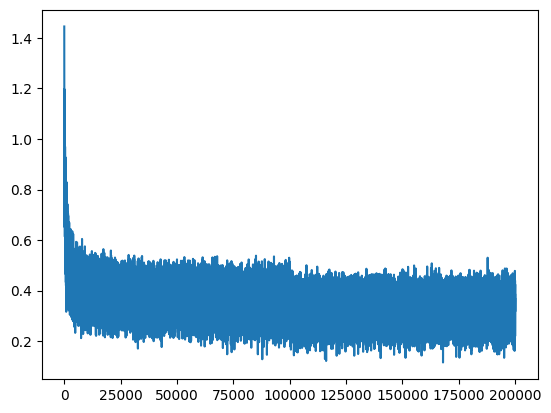

In [ ]:
# plt.plot(lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking, more efficient
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1

  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0668270587921143
val 2.104844808578491


In [ ]:
# @torch.no_grad() # this decorator disables gradient tracking, more efficient
# def split_loss(split):
#   x,y = {
#     'train': (Xtr, Ytr),
#     'val': (Xdev, Ydev),
#     'test': (Xte, Yte),
#   }[split]
#   emb = C[x] # (N, block_size, n_embd)
#   embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
#   hpreact = embcat @ W1  + b1
#   # #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
#   # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
#   h = torch.tanh(hpreact) # (N, n_hidden)
#   logits = h @ W2 + b2 # (N, vocab_size)
#   loss = F.cross_entropy(logits, y)
#   print(split, loss.item())

# split_loss('train')
# split_loss('val')


train 2.127678871154785
val 2.1750576496124268


In [ ]:
# loss log
# original:
train 2.1245384216308594 val 2.168196439743042

# fix softmax confidently wrong: making W2 very small, b2 0
train 2.07 val 2.13

# fix tanh layer too saturated at init: making W1, b1 very small
train 2.0355966091156006 val 2.1026785373687744

# use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693 val 2.106989622116089



In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1  + b1
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
seel.
nehayla.
remyra.
endrael.
adeer.
melin.
shy.
jen.
ede.
seananaraelyn.
malya.
cayshubergiaghan.
trickontelionnie.
cayus.
mace.
ryyah.
fael.
youe.
